# Supervised Algorithms For The Detection Of COVID-19 From Chest CT Scan Images

### Import necessary libraries

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from imutils import paths
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import mahotas
%matplotlib inline

### Extract the Raw Pixel Intensities

In [2]:
def image_to_feature_vector(image):
	return cv2.resize(image, (60, 60)).flatten()

### Extract a 3D color histogram from the HSV colorspace to characterize the color distribution of the pixels in the images

In [3]:
def extract_color_histogram(image, bins=(8, 8, 8)):
#Extract using the supplied number of `bins` per channel,\
#then perform "in place" normalization in OpenCV, and return the flattened histogram as the feature vector
	hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
	hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
		[0, 256, 0, 256, 0, 256])
	cv2.normalize(hist, hist)
	return hist.flatten()

### Extract the Haralick Texture features using Mahotas, and return the feature vector

In [4]:
def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Haralick Texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

### Extract the Threshold Adjacency Statistics features using Mahotas, and return the feature vector

In [5]:
def fd_tas(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the Threshold Adjacency Statistics feature vector
    value = mahotas.features.tas(gray) 
    return value

### Specify the directory for the CT scan images, and initialize the matrices

In [6]:
# grab the list of images that we'll be describing
print("[INFO] Loading images...")
imagePaths = list(paths.list_images("Images-processed/"))
rawImages = []
histogram = []
hara = []
tas = []
labels = []

[INFO] Loading images...


### Loop over the input images:
#### 1) load the image and extract the class label (assuming that our path is in the format: /path/to/dataset/{class}.{image_num}.jpg
#### 2) extract the Raw Pixel Intensity, the Color Histogram, the Haralick Texture, and Threshold Adjacency Statistics features
#### 3) update the matricies respectively

In [7]:
for (i, imagePath) in enumerate(imagePaths):

	image = cv2.imread(imagePath)
	label = imagePath.split(os.path.sep)[-1].split(".")[0]

	pixels = image_to_feature_vector(image)
	haralick = fd_haralick(image)
	tass = fd_tas(image)
	hist = extract_color_histogram(image)
    

	rawImages.append(pixels)
	histogram.append(hist)
	tas.append(tass)
	hara.append(haralick)
	labels.append(label)
    
	if i > 0 and i % 100 == 0:    # show an update every 100 images
		print("[INFO] Processed {}/{}".format(i, len(imagePaths)))
print("[INFO] Processed {}/{}".format(i+1, len(imagePaths)))

[INFO] Processed 100/2481
[INFO] Processed 200/2481
[INFO] Processed 300/2481
[INFO] Processed 400/2481
[INFO] Processed 500/2481
[INFO] Processed 600/2481
[INFO] Processed 700/2481
[INFO] Processed 800/2481
[INFO] Processed 900/2481
[INFO] Processed 1000/2481
[INFO] Processed 1100/2481
[INFO] Processed 1200/2481
[INFO] Processed 1300/2481
[INFO] Processed 1400/2481
[INFO] Processed 1500/2481
[INFO] Processed 1600/2481
[INFO] Processed 1700/2481
[INFO] Processed 1800/2481
[INFO] Processed 1900/2481
[INFO] Processed 2000/2481
[INFO] Processed 2100/2481
[INFO] Processed 2200/2481
[INFO] Processed 2300/2481
[INFO] Processed 2400/2481
[INFO] Processed 2481/2481


### Show some information on the memory consumed each matrix

In [85]:
rawImages = np.array(rawImages)
histogram = np.array(histogram)
labels = np.array(labels)
hara = np.array(hara)
tas = np.array(tas)
features = np.concatenate((hara, tas), axis=1)
features = np.concatenate((features, histogram), axis=1)

print("[INFO] pixels matrix: {:.2f}MB".format(
	rawImages.nbytes / (1024 * 1000.0)))
print("[INFO] histogram matrix: {:.2f}MB".format(
	histogram.nbytes / (1024 * 1000.0)))
print("[INFO] haralick matrix: {:.2f}MB".format(
    hara.nbytes / (1024 * 1000.0)))
print("[INFO] TAS matrix: {:.2f}MB".format(
    tas.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    features.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 26.17MB
[INFO] histogram matrix: 4.96MB
[INFO] haralick matrix: 0.25MB
[INFO] TAS matrix: 1.05MB
[INFO] features matrix: 11.22MB


### Split partition the data into training and testing splits, using 80% of the data for training and 20% for testing

In [71]:
(trainRI, testRI, trainRL, testRL) = train_test_split(rawImages, labels, test_size=0.20, random_state=10)
(trainHara, testHara, trainHaraL, testHaraL) = train_test_split(hara, labels, test_size=0.20, random_state=10)
(trainTas, testTas, trainTasL, testTasL) = train_test_split(tas, labels, test_size=0.20, random_state=10)
(trainFeat, testFeat, trainLabels, testLabels) = train_test_split(histogram, labels, test_size=0.20, random_state=10)

(trainF, testF, trainFL, testFL) = train_test_split(features, labels, test_size=0.20, random_state=10)

## A. Training the algorithms using the Raw Pixel Intensities

### Show a sample of CT Scan Images

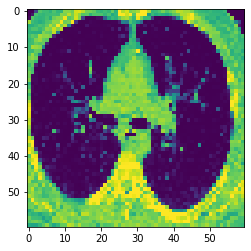

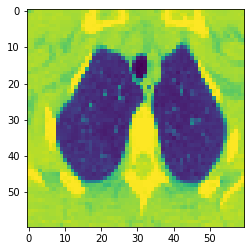

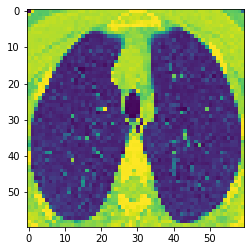

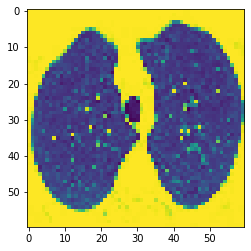

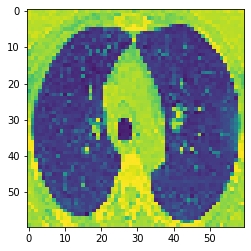

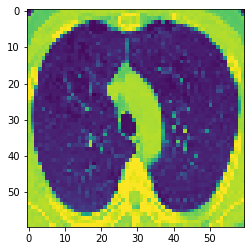

In [8]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (60, 60))
    plt.imshow(img)
    plt.show()

### Specify the inputs

In [12]:
X = rawImages
y = labels
X_train = trainRI
X_test = testRI
y_train = trainRL
y_test = testRL

### Perform standardization by centering and scaling the training set and the test set

In [13]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Train and evaluate a k-NN classifer on the raw pixel intensities

In [14]:
print("[INFO] evaluating k-NN raw pixel accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN raw pixel accuracy...
[INFO] k-NN raw pixel accuracy: 94.37%


In [15]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.94      0.95       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497



### Train and evaluate a Linear SVM classifer on the raw pixel intensities

In [16]:
print("[INFO] evaluating Linear SVM raw pixel accuracy...")
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating Linear SVM raw pixel accuracy...
[INFO] Linear SVM raw pixel accuracy: 76.86%


In [17]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.77      0.74      0.75       238
   NON_COVID       0.77      0.80      0.78       259

    accuracy                           0.77       497
   macro avg       0.77      0.77      0.77       497
weighted avg       0.77      0.77      0.77       497



### Train and evaluate an SVM classifer using the RBF kernel on the raw pixel intensities

#### 1) using C parameter = 10

In [18]:
print("[INFO] evaluating RBF SVM raw pixel accuracy with C=10...")
rbf_svc = svm.SVC(kernel='rbf', C = 10, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=10: {:.2f}%".format(acc * 100))

[INFO] evaluating RBF SVM raw pixel accuracy with C=10...
[INFO] RBF SVM raw pixel accuracy with C=10: 95.98%


In [19]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.97      0.95      0.96       238
   NON_COVID       0.95      0.97      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497



#### 2) using C parameter = 1

In [20]:
print("[INFO] evaluating RBF SVM raw pixel accuracy with C=1...")
rbf_svc = svm.SVC(kernel='rbf', C = 1, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=1: {:.2f}%".format(acc * 100))

[INFO] evaluating RBF SVM raw pixel accuracy with C=1...
[INFO] RBF SVM raw pixel accuracy with C=1: 92.15%


In [21]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.93      0.90      0.92       238
   NON_COVID       0.91      0.94      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



#### 3) using C parameter = 0.1

In [22]:
print("[INFO] evaluating RBF SVM raw pixel accuracy with C=0.1...")
rbf_svc = svm.SVC(kernel='rbf', C = 0.1, gamma = 'scale')
rbf_svc.fit(X_train, y_train)
acc = rbf_svc.score(X_test, y_test)
print("[INFO] RBF SVM raw pixel accuracy with C=0.1: {:.2f}%".format(acc * 100))

[INFO] evaluating RBF SVM raw pixel accuracy with C=0.1...
[INFO] RBF SVM raw pixel accuracy with C=0.1: 79.68%


In [23]:
y_pred = rbf_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.84      0.71      0.77       238
   NON_COVID       0.77      0.87      0.82       259

    accuracy                           0.80       497
   macro avg       0.80      0.79      0.79       497
weighted avg       0.80      0.80      0.80       497



### Train and evaluate a Decision Tree Classifier on the raw pixel intensities

In [24]:
print("[INFO] evaluating Decision Tree raw pixel accuracy...")
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer using default parameters
dt = dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
acc = dt.score(X_test, y_test)
print("[INFO] Decision Tree raw pixel accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] evaluating Decision Tree raw pixel accuracy...
[INFO] Decision Tree raw pixel accuracy: 76.26%
              precision    recall  f1-score   support

       COVID       0.75      0.76      0.75       238
   NON_COVID       0.77      0.77      0.77       259

    accuracy                           0.76       497
   macro avg       0.76      0.76      0.76       497
weighted avg       0.76      0.76      0.76       497



### Train and evaluate a Voting Classifier with hard voting on the raw pixel intensities

In [25]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma = 'scale')))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [26]:
acc = vot_hard.score(X_test, y_test)
print("[INFO] Voting Classifier raw pixel accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Voting Classifier raw pixel accuracy: 96.58%
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.96       238
   NON_COVID       0.96      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



## B. Training the algorithms using the Color Histogram features

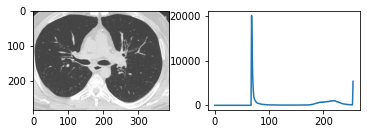

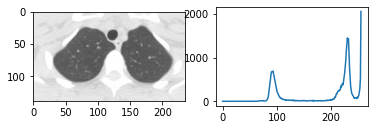

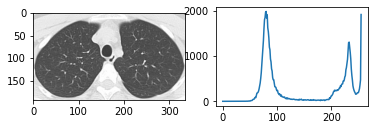

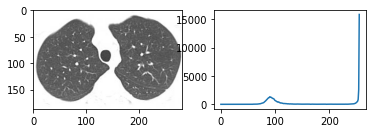

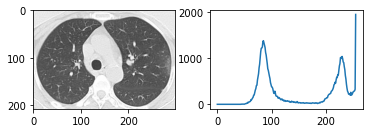

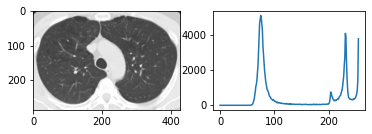

In [9]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 6: break
    img = cv2.imread(imagePath)
    hist_full = cv2.calcHist([img],[0],None,[256],[0,256])
    plt.subplot(221), plt.imshow(img, 'gray')
    plt.subplot(222), plt.plot(hist_full)
    plt.show()

### Specify the inputs

In [27]:
X = histogram
y = labels
X_train = trainFeat
X_test = testFeat
y_train = trainLabels
y_test = testLabels

### Perform standardization by centering and scaling the training set and the test set

In [28]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

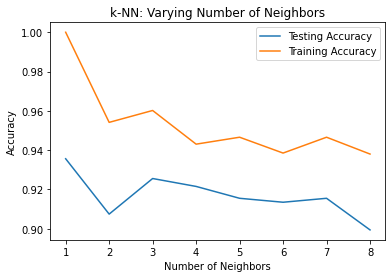

In [29]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the color histogram representations

In [30]:
print("[INFO] evaluating k-NN color histogram accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN color histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN color histogram accuracy...
[INFO] k-NN color histogram accuracy: 92.56%


In [31]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.90      0.95      0.92       238
   NON_COVID       0.95      0.91      0.93       259

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497



### Train and evaluate a Linear SVM classifer on the color histogram representations

In [32]:
print("[INFO] evaluating Linear SVM color histogram accuracy...")
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM color histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating Linear SVM color histogram accuracy...
[INFO] Linear SVM color histogram accuracy: 86.72%


In [33]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.92      0.79      0.85       238
   NON_COVID       0.83      0.93      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.86      0.87       497
weighted avg       0.87      0.87      0.87       497



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the color histogram representations and print the classification report for the model

In [34]:
steps = [('scaler', StandardScaler()),
         ('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("[INFO] RBF SVM color histogram accuracy: {:.2f}%".format(cv.score(X_test, y_test)*100))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

[INFO] RBF SVM color histogram accuracy: 93.96%
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94       238
   NON_COVID       0.94      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 1}


### Plot the Percision-Recall Curve

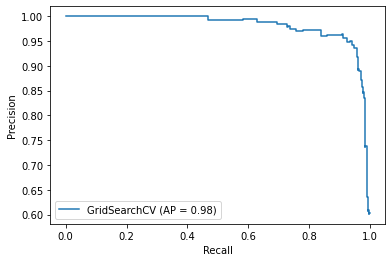

In [35]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
disp = plot_precision_recall_curve(cv, X_test, y_test)

### Train and evaluate a Decision Tree Classifier

In [36]:
print("[INFO] evaluating Decision Tree color histogram accuracy...")
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer using default parameters
dt = dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
acc = dt.score(X_test, y_test)
print("[INFO] Decision Tree accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] evaluating Decision Tree color histogram accuracy...
[INFO] Decision Tree accuracy: 92.35%
              precision    recall  f1-score   support

       COVID       0.92      0.92      0.92       238
   NON_COVID       0.93      0.93      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



### Train and evaluate a Voting Classifier with hard voting on the Color Histogram features

In [37]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma = 1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [38]:
acc = vot_hard.score(X_test, y_test)
print("[INFO] Voting Classifier Color Histogram accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Voting Classifier Color Histogram accuracy: 94.16%
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94       238
   NON_COVID       0.95      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497



## C. Training the algorithms using the Haralick Texture features

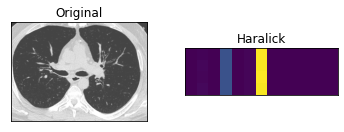

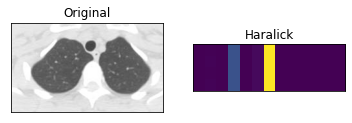

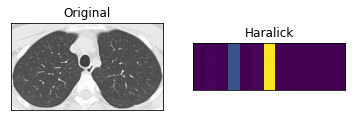

In [39]:
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 3: break
    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray)
    plt.subplot(2,2,1),plt.imshow(img, cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(haralick)
    plt.title('Haralick'), plt.xticks([]), plt.yticks([])
    plt.show()

### Specify the inputs

In [40]:
X = hara
y = labels
X_train = trainHara
X_test = testHara
y_train = trainHaraL
y_test = testHaraL

### Perform standardization by centering and scaling the training set and the test set

In [41]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

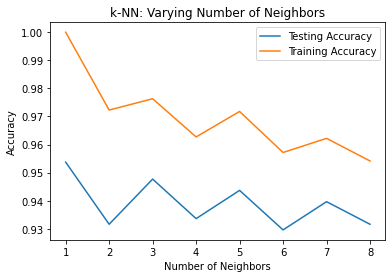

In [42]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Haralick Texture features

In [43]:
print("[INFO] evaluating k-NN Haralick Texture accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN Haralick Texture accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN Haralick Texture accuracy...
[INFO] k-NN Haralick Texture accuracy: 94.77%


In [44]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.93      0.96      0.95       238
   NON_COVID       0.96      0.94      0.95       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497



### Train and evaluate a Linear SVM classifer on the Haralick Texture features

In [45]:
print("[INFO] evaluating Linear SVM Haralick Texture accuracy...")
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM Haralick Texture accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating Linear SVM Haralick Texture accuracy...
[INFO] Linear SVM Haralick Texture accuracy: 88.33%


In [46]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.90      0.85      0.87       238
   NON_COVID       0.87      0.92      0.89       259

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the Haralick Texture features and print the classification report for the model

In [47]:
steps = [('scaler', StandardScaler()),
         ('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("[INFO] RBF SVM histogram accuracy: {:.2f}%".format(cv.score(X_test, y_test)*100))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

[INFO] RBF SVM histogram accuracy: 96.18%
              precision    recall  f1-score   support

       COVID       0.95      0.97      0.96       238
   NON_COVID       0.97      0.96      0.96       259

    accuracy                           0.96       497
   macro avg       0.96      0.96      0.96       497
weighted avg       0.96      0.96      0.96       497

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 1}


### Train and evaluate a Decision Tree Classifier on the Haralick Texture representations

In [48]:
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer using default parameters
dt = dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
acc = dt.score(X_test, y_test)
print("[INFO] Decision Tree Haralick Texture accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Decision Tree Haralick Texture accuracy: 88.73%
              precision    recall  f1-score   support

       COVID       0.87      0.90      0.88       238
   NON_COVID       0.90      0.88      0.89       259

    accuracy                           0.89       497
   macro avg       0.89      0.89      0.89       497
weighted avg       0.89      0.89      0.89       497



### Train and evaluate a Voting Classifier with hard voting on the Haralick Texture representations

In [49]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=100, gamma = 1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [50]:
acc = vot_hard.score(X_test, y_test)
print("[INFO] Voting Classifier Haralick Texture accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Voting Classifier Haralick Texture accuracy: 95.37%
              precision    recall  f1-score   support

       COVID       0.95      0.96      0.95       238
   NON_COVID       0.96      0.95      0.96       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497



## D. Training the algorithms using Threshold Adjacency Statistics

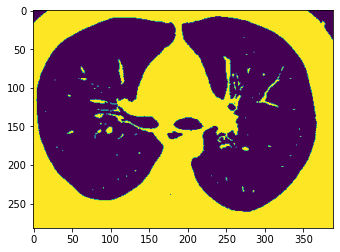

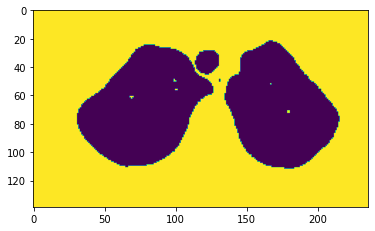

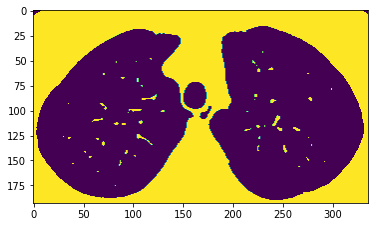

In [51]:
from pylab import imshow, gray, show
from os import path
imagePaths = list(paths.list_images("Images-processed/"))
for (i, imagePath) in enumerate(imagePaths):
    if i>= 3: break
    img = cv2.imread(imagePath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray.astype(np.uint8)
    T_rc = mahotas.rc(gray)
    imshow(gray > T_rc)
    show()

### Specify the inputs

In [52]:
X = tas
y = labels
X_train = trainTas
X_test = testTas
y_train = trainTasL
y_test = testTasL

### Perform standardization by centering and scaling the training set and the test set

In [53]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

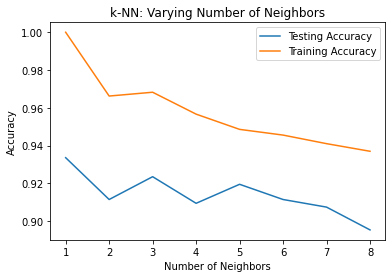

In [54]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Threshold Adjacency Statistics (TAS)

In [55]:
print("[INFO] evaluating k-NN TAS accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN TAS accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN TAS accuracy...
[INFO] k-NN TAS accuracy: 92.35%


In [56]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.93      0.91      0.92       238
   NON_COVID       0.92      0.94      0.93       259

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497



### Train and evaluate a Linear SVM classifer on the TAS representations

In [57]:
print("[INFO] evaluating Linear SVM TAS accuracy...")
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM TAS accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating Linear SVM TAS accuracy...
[INFO] Linear SVM TAS accuracy: 87.73%


In [58]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.87      0.87      0.87       238
   NON_COVID       0.88      0.88      0.88       259

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [59]:
steps = [('scaler', StandardScaler()),
         ('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("[INFO] RBF SVM TAS accuracy: {:.2f}%".format(cv.score(X_test, y_test)*100))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

[INFO] RBF SVM TAS accuracy: 93.76%
              precision    recall  f1-score   support

       COVID       0.93      0.94      0.94       238
   NON_COVID       0.94      0.94      0.94       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


### Train and evaluate a Decision Tree Classifier on the TAS representations

In [60]:
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer using default parameters
dt = dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
acc = dt.score(X_test, y_test)
print("[INFO] Decision Tree TAS accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Decision Tree TAS accuracy: 87.32%
              precision    recall  f1-score   support

       COVID       0.85      0.89      0.87       238
   NON_COVID       0.90      0.85      0.88       259

    accuracy                           0.87       497
   macro avg       0.87      0.87      0.87       497
weighted avg       0.87      0.87      0.87       497



### Train and evaluate a Voting Classifier with hard voting on the TAS representations

In [61]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='rbf', C=10, gamma=0.1)))
estimator.append(('3', dt))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [62]:
acc = vot_hard.score(X_test, y_test)
print("[INFO] Voting Classifier TAS accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Voting Classifier TAS accuracy: 94.37%
              precision    recall  f1-score   support

       COVID       0.95      0.93      0.94       238
   NON_COVID       0.94      0.95      0.95       259

    accuracy                           0.94       497
   macro avg       0.94      0.94      0.94       497
weighted avg       0.94      0.94      0.94       497



## E. Training the algorithms using all the features (Color Histogram, Haralink, & TAS)

### Specify the inputs

In [72]:
X = features
y = labels
X_train = trainF
X_test = testF
y_train = trainFL
y_test = testFL

### Perform standardization by centering and scaling the training set and the test set

In [73]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

### Find the best k to use for the k-NN classifier

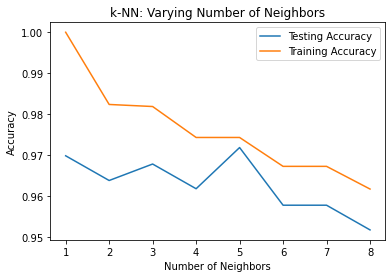

In [82]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Train and evaluate a k-NN classifer on the Features matrix

In [87]:
print("[INFO] evaluating k-NN Features accuracy...")
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
acc = knn.score(X_test, y_test)
print("[INFO] k-NN Features accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating k-NN Features accuracy...
[INFO] k-NN Features accuracy: 96.78%


In [75]:
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.97      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



### Train and evaluate a Linear SVM classifer on the TAS representations

In [76]:
print("[INFO] evaluating Linear SVM Features accuracy...")
linear_svc = svm.SVC(kernel='linear')
linear_svc.fit(X_train, y_train)
acc = linear_svc.score(X_test, y_test)
print("[INFO] Linear SVM Features accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating Linear SVM TAS accuracy...
[INFO] Linear SVM TAS accuracy: 94.57%


In [77]:
y_pred = linear_svc.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       COVID       0.94      0.95      0.94       238
   NON_COVID       0.95      0.95      0.95       259

    accuracy                           0.95       497
   macro avg       0.95      0.95      0.95       497
weighted avg       0.95      0.95      0.95       497



### Perform GridSearchCV to find the best RBF kernel parameters for an SVM model

#### Train and evaluate an RBF SVM classifer on the TAS representations and print the classification report for the model

In [78]:
steps = [('scaler', StandardScaler()),
         ('SVM', svm.SVC())]

pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[0.1, 1, 10, 100],
              'SVM__gamma':[0.1, 1, 10, 100]}

# Instantiate the GridSearchCV object: cv
cv = GridSearchCV(pipeline, param_grid=parameters)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set: y_pred
y_pred = cv.predict(X_test)

# Compute and print metrics
print("[INFO] RBF SVM Features accuracy: {:.2f}%".format(cv.score(X_test, y_test)*100))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

[INFO] RBF SVM TAS accuracy: 96.78%
              precision    recall  f1-score   support

       COVID       0.97      0.96      0.97       238
   NON_COVID       0.96      0.98      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


### Train and evaluate a Decision Tree Classifier on the TAS representations

In [79]:
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer using default parameters
dt = dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = dt.predict(X_test)
acc = dt.score(X_test, y_test)
print("[INFO] Decision Tree TAS accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Decision Tree TAS accuracy: 91.15%
              precision    recall  f1-score   support

       COVID       0.92      0.89      0.91       238
   NON_COVID       0.91      0.93      0.92       259

    accuracy                           0.91       497
   macro avg       0.91      0.91      0.91       497
weighted avg       0.91      0.91      0.91       497



### Train and evaluate a Voting Classifier with hard voting on the Features matrix

In [80]:
estimator = []
estimator.append(('1', knn))
estimator.append(('2', svm.SVC(kernel='linear')))
estimator.append(('3', svm.SVC(kernel='rbf', C=10, gamma=0.1)))

# Voting Classifier with hard voting
vot_hard = VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(X_train, y_train)
y_pred = vot_hard.predict(X_test)

In [81]:
acc = vot_hard.score(X_test, y_test)
print("[INFO] Voting Classifier Features accuracy: {:.2f}%".format(acc * 100))
print(classification_report(y_test, y_pred))

[INFO] Voting Classifier Features accuracy: 97.18%
              precision    recall  f1-score   support

       COVID       0.97      0.97      0.97       238
   NON_COVID       0.97      0.97      0.97       259

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497

